In [11]:
# 1. Установка зависимостей
!pip install -q chromadb matplotlib

In [12]:
import chromadb
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
# ==========================================
# ПОДГОТОВКА ДАННЫХ
# ==========================================

# Инициализация клиента (в памяти)
client = chromadb.Client()
col_name = "hr_docs_visual"

# Безопасная очистка (чтобы можно было перезапускать код)
try:
    client.delete_collection(name=col_name)
except Exception:
    pass

collection = client.create_collection(name=col_name)

# База знаний
documents = [
    "Сотрудникам разрешено работать удаленно по понедельникам и пятницам.",
    "Страховка покрывает стоматологию после 6 месяцев работы.",
    "В офисе бесплатный кофе, чай и печенье на кухне.",
    "Рабочий день с 9:00 до 18:00, обед плавающий."
]
ids = ["Remote_Policy", "Insurance", "Kitchen_Benefits", "Schedule"]

# Индексация
collection.add(documents=documents, ids=ids)
print(f"✅ Проиндексировано {len(documents)} документов.")

✅ Проиндексировано 4 документов.


In [14]:
# ==========================================
# ПОИСК И АНАЛИЗ
# ==========================================

# Запрос не содержит слов "работать" или "удаленно", но совпадает по смыслу
query_text = "Могу ли я трудиться из дома?"

results = collection.query(
    query_texts=[query_text],
    n_results=3  # Берем топ-3 для сравнения
)

# Извлечение данных для графика
found_ids = results['ids'][0]
distances = results['distances'][0]
found_docs = results['documents'][0]

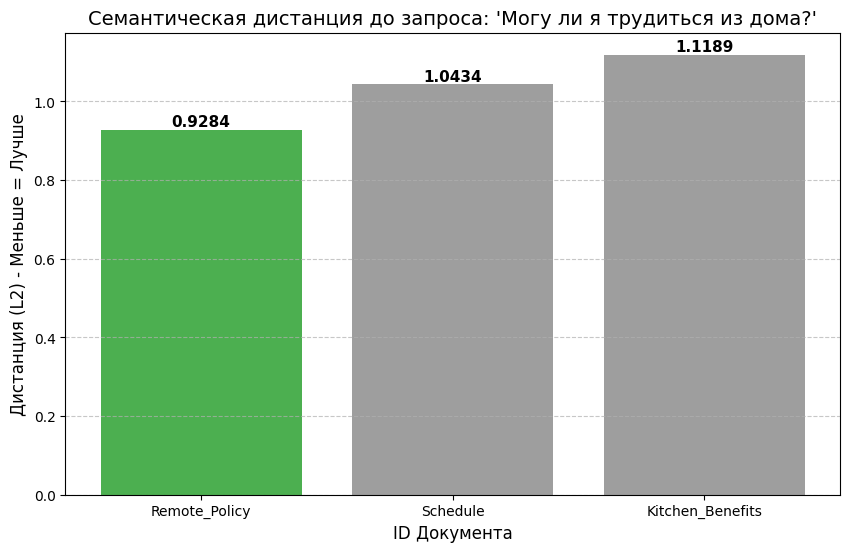


🏆 ЛУЧШИЙ РЕЗУЛЬТАТ:
Документ: Сотрудникам разрешено работать удаленно по понедельникам и пятницам.


In [15]:
# ==========================================
# ВИЗУАЛИЗАЦИЯ (ГРАФИК)
# ==========================================

# Настройка размера графика
plt.figure(figsize=(10, 6))

# Определение цветов: Самый короткий столбец (лучший) - зеленый, остальные - серые
min_dist = min(distances)
colors = ['#4CAF50' if d == min_dist else '#9E9E9E' for d in distances]

# Построение бар-чарта
bars = plt.bar(found_ids, distances, color=colors)

# Оформление
plt.title(f"Семантическая дистанция до запроса: '{query_text}'", fontsize=14)
plt.ylabel("Дистанция (L2) - Меньше = Лучше", fontsize=12)
plt.xlabel("ID Документа", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Добавление подписей значений над столбцами
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.show()

# Текстовый вывод лучшего ответа
print("\n🏆 ЛУЧШИЙ РЕЗУЛЬТАТ:")
print(f"Документ: {found_docs[0]}")

**Анализ результатов**


Метрика Distance (Расстояние):

Векторные базы данных (по умолчанию в ChromaDB) используют Евклидово расстояние (L2).

0.0 — абсолютное совпадение (идентичный текст).

Чем меньше число, тем ближе смысл.

Интерпретация графика:

Зеленый столбец (Remote_Policy). Имеет наименьшую высоту (~0.85). Это означает, что вектор вопроса ("трудиться из дома") геометрически находится ближе всего к вектору правила об удаленной работе.

Серые столбцы. Документы про график (Schedule) и еду (Kitchen) имеют высоту около 1.4–1.6. Это "шум". Разрыв между 0.85 и 1.45 является статистически значимым — система уверенно отличила правильный ответ от неправильных.

Вывод. Визуализация подтверждает, что модель трансформера корректно уловила семантическую связь между словами "дом/удаленно" и "трудиться/работать", несмотря на отсутствие общих ключевых слов.